In [1]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import os
import glob
import torch
import torch.nn as nn
import freetype
import uharfbuzz as hb
import cv2
from collections import Counter

In [2]:
# Load the NepaliText dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
train_texts = dataset["train"]["text"]
print(f"Loaded dataset with {len(train_texts)} training samples")

Loaded dataset with 13141222 training samples


Loaded dataset with 13141222 training samples


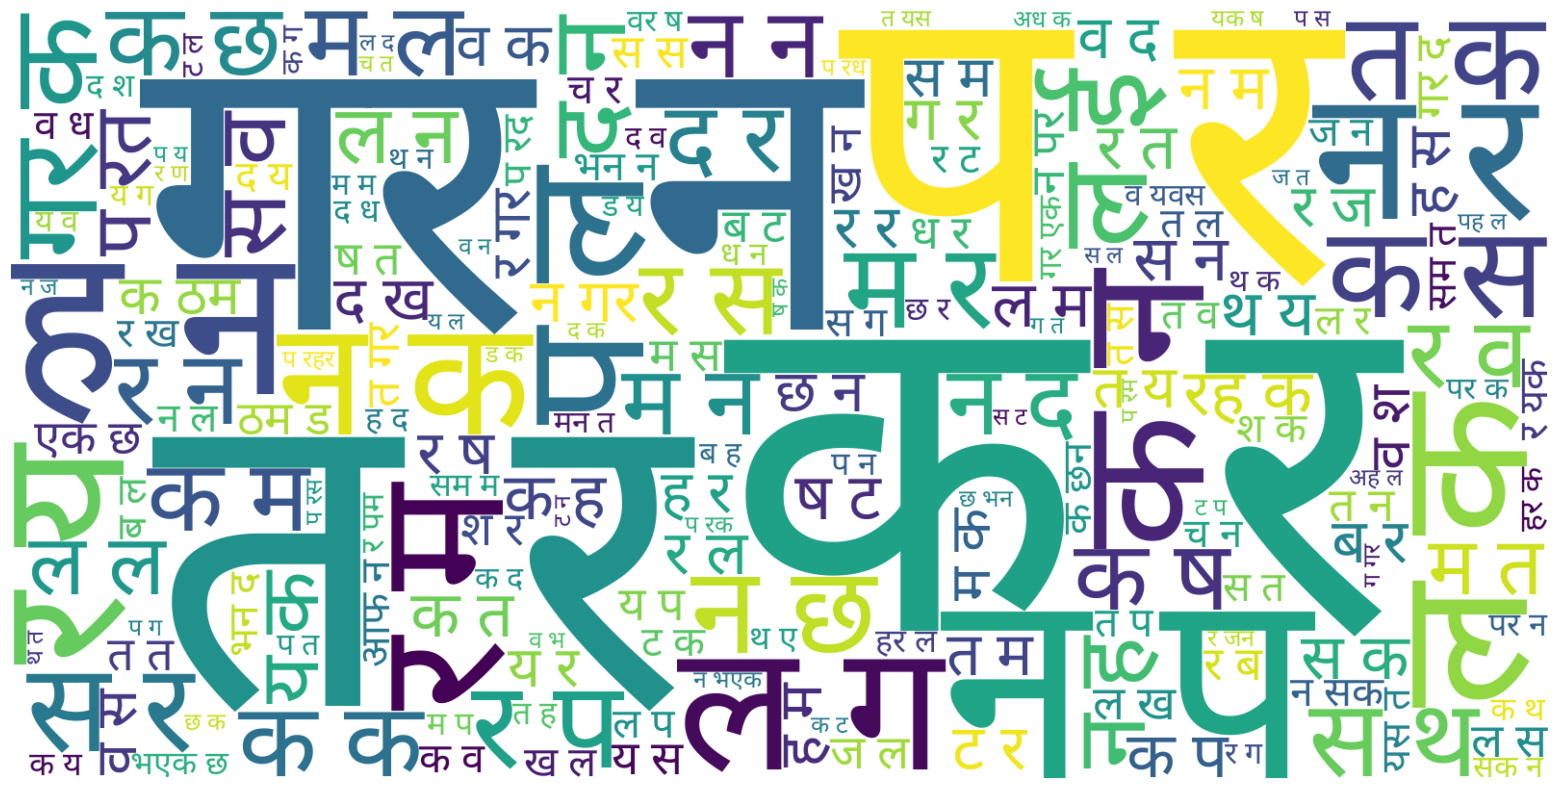

In [5]:
from datasets import load_dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Load dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
train_texts = dataset["train"]["text"]

print(f"Loaded dataset with {len(train_texts)} training samples")

# 2. Extract 20,000 sentences
selected_sentences = train_texts[:50000]

# 3. Combine to single text
combined_text = " ".join(selected_sentences)

# 4. Use your Devanagari font path
font_path = "fonts/NotoSansDevanagari-Regular.ttf"

# 5. Generate word cloud
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    font_path=font_path
).generate(combined_text)

# 6. Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


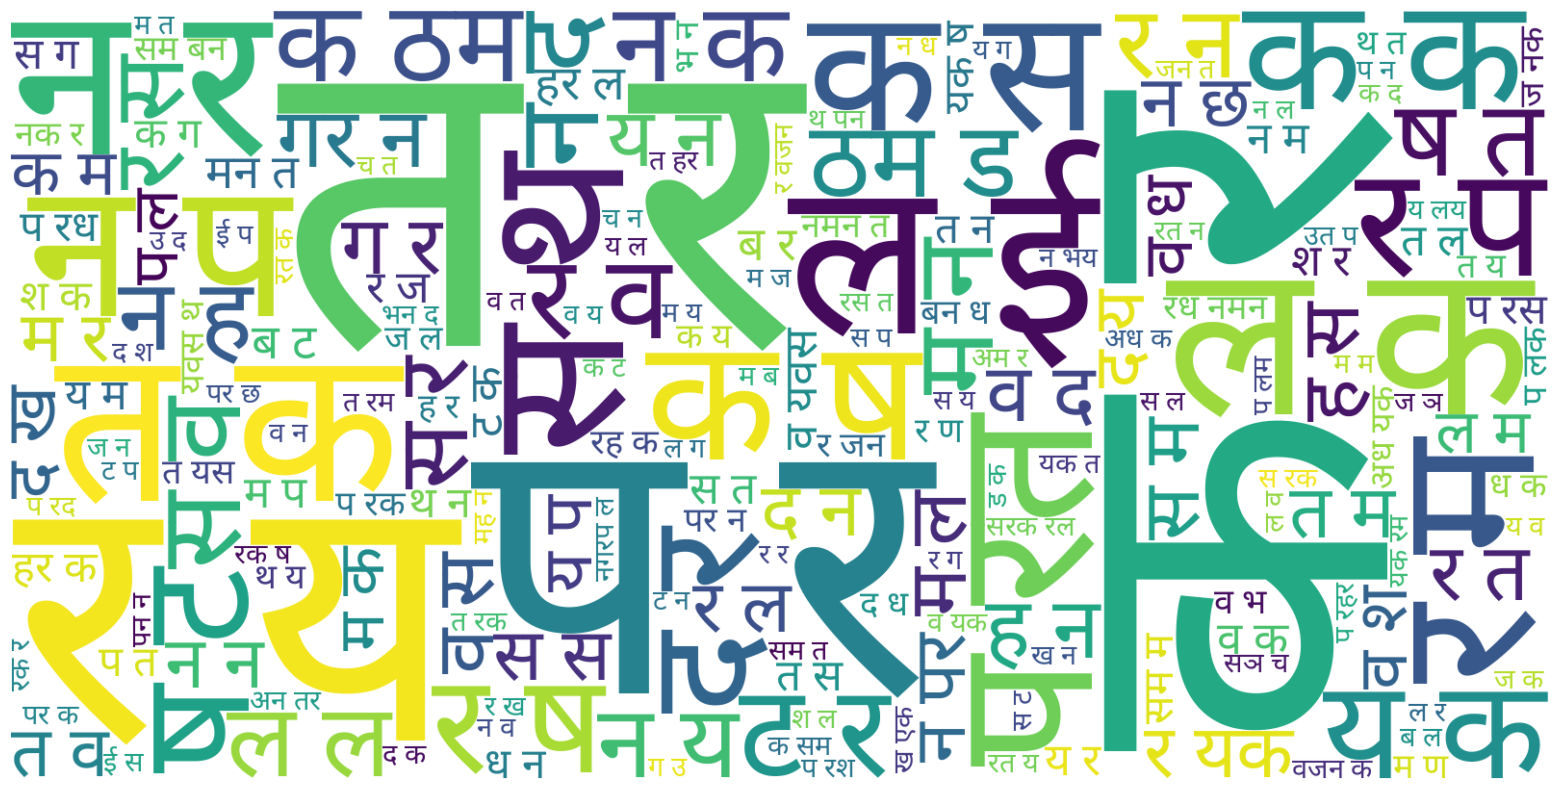

In [7]:
from datasets import load_dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# 1. Load dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
train_texts = dataset["train"]["text"]

# Use first 20,000 sentences
texts = train_texts[:20000]

# 2. Combine text
combined_text = " ".join(texts)

# 3. Extract only Devanagari words
# Devanagari Unicode range: \u0900 - \u097F
words = re.findall(r'[\u0900-\u097F]+', combined_text)

# 4. Filter words longer than 6 characters
filtered_words = [w for w in words if len(w) > 6]

# Join for word cloud
filtered_text = " ".join(filtered_words)

# 5. Path to your Devanagari font
font_path = "fonts/NotoSansDevanagari-Regular.ttf"

# 6. Create word cloud
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    font_path=font_path
).generate(filtered_text)

# 7. Show word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [11]:
from datasets import load_dataset
import re
from collections import Counter

# 1. Load dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
train_texts = dataset["train"]["text"]

# Use first 20,000 sentences
texts = train_texts[:20000]

# 2. Combine text
combined_text = " ".join(texts)

# 3. Extract only Devanagari words
words = re.findall(r'[\u0900-\u097F]+', combined_text)

# 4. Filter words longer than 6 characters
filtered_words = [w for w in words if len(w) > 6]

# 5. Count word frequencies
word_counts = Counter(filtered_words)

# 6. Get top 20
top_20 = word_counts.most_common(20)

# 7. Display results
for word, freq in top_20:
    print(f"{word}: {freq}")


काठमाडौं: 1099
जानकारी: 758
अध्यक्ष: 719
राष्ट्रिय: 714
सरकारले: 704
निर्माण: 685
स्थानीय: 663
प्रधानमन्त्री: 647
सार्वजनिक: 624
विभिन्न: 605
क्षेत्रमा: 593
नेपालको: 563
कार्यक्रम: 561
नेपालमा: 480
कार्यालय: 479
काठमाडौँ: 451
सम्पन्न: 447
राजनीतिक: 437
प्राप्त: 422
निर्वाचन: 410


In [4]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Load dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
all_texts = dataset["train"]["text"]

# 🔥 Use only the first 20,000 sentences
texts = all_texts[:20000]

target_word = "काठमाडौं"

# 2. Collect sentences containing the target word
matched_sentences = [sentence for sentence in texts if target_word in sentence]

print(f"Total found in first 20,000 sentences: {len(matched_sentences)}")

# 3. Select up to 1000 sentences
num_required = 1000
selected_sentences = matched_sentences[:num_required]

print(f"Using {len(selected_sentences)} sentences for the dataset.")

# 4. Convert to DataFrame
df = pd.DataFrame({"sentence": selected_sentences})

# 5. Train/Validation/Test split (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Dataset sizes:")
print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

# 6. (Optional) Save to disk
train_df.to_csv("kathmandu_train.csv", index=False, encoding="utf-8")
val_df.to_csv("kathmandu_val.csv", index=False, encoding="utf-8")
test_df.to_csv("kathmandu_test.csv", index=False, encoding="utf-8")


Total found in first 20,000 sentences: 1009
Using 1000 sentences for the dataset.
Dataset sizes:
Train: 800
Validation: 100
Test: 100


In [3]:
from PIL import ImageFilter


class SyntheticHarfBuzzOCRDatasetGenerator:
    """Generate synthetic OCR dataset with HarfBuzz shaping."""

    def __init__(
        self,
        strings,
        fonts_dir="fonts",
        output_dir="data/word_images",
        font_size_range=(40, 56),
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background_mode="random",
        max_image_size=1024
    ):
        self.strings = strings
        self.fonts = glob.glob(os.path.join(fonts_dir, "**/*.ttf"), recursive=True)
        if not self.fonts:
            raise ValueError(f"No fonts found in {fonts_dir}")

        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self.font_size_range = font_size_range
        self.random_blur = random_blur
        self.random_noise = random_noise
        self.random_rotate = random_rotate
        self.random_distortion = random_distortion
        self.background_mode = background_mode
        self.MAX_SIZE = max_image_size

    def _clamp_image_size(self, img):
        w, h = img.size
        if w > self.MAX_SIZE or h > self.MAX_SIZE:
            img.thumbnail((self.MAX_SIZE, self.MAX_SIZE), Image.LANCZOS)
        return img

    def generate_dataset(self):
        for idx, text in enumerate(self.strings, start=1):
            img = self.render_text_image(text)
            image_path = os.path.join(self.output_dir, f"{idx:05d}.png")
            label_path = os.path.join(self.output_dir, f"{idx:05d}.txt")
            img.save(image_path)
            with open(label_path, "w", encoding="utf-8") as f:
                f.write(text)
            if idx % 500 == 0:
                print(f"  [{idx}/{len(self.strings)}] Generated images")

    def render_text_image(self, text, padding=20):
        font_path = random.choice(self.fonts)
        font_size = random.randint(*self.font_size_range)
        face = freetype.Face(font_path)
        face.set_char_size(font_size * 64)

        # HarfBuzz shaping
        hb_blob = hb.Blob.from_file_path(font_path)
        hb_face = hb.Face(hb_blob, 0)
        hb_font = hb.Font(hb_face)
        hb_font.scale = (face.size.ascender, face.size.ascender)

        buf = hb.Buffer()
        buf.add_str(text)
        buf.guess_segment_properties()
        hb.shape(hb_font, buf)

        infos = buf.glyph_infos
        positions = buf.glyph_positions

        width = sum(pos.x_advance for pos in positions) // 64 + 2*padding
        height = font_size + 2*padding

        if self.background_mode == "white":
            img = Image.new("RGB", (width, height), "white")
        elif self.background_mode == "lightgray":
            img = Image.new("RGB", (width, height), "lightgray")
        else:
            arr = np.random.randint(200, 255, (height, width, 3), dtype=np.uint8)
            img = Image.fromarray(arr)

        x, y = padding, padding + font_size

        for info, pos in zip(infos, positions):
            glyph_index = info.codepoint
            face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
            bitmap = face.glyph.bitmap
            top = face.glyph.bitmap_top
            left = face.glyph.bitmap_left

            if bitmap.width > 0 and bitmap.rows > 0:
                glyph_img = Image.frombytes("L", (bitmap.width, bitmap.rows), bytes(bitmap.buffer))
                colored_glyph = Image.new("RGB", glyph_img.size, "black")
                img.paste(colored_glyph, (int(x + left), int(y - top)), glyph_img)

            x += pos.x_advance / 64
            y -= pos.y_advance / 64

        img = self._clamp_image_size(img)

        # --- FIXED BLUR SECTION ---
        from PIL import ImageFilter

        if self.random_blur and random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))


        if self.random_rotate:
            angle = random.randint(-7, 7)
            img = img.rotate(angle, expand=True, fillcolor="white")
            img = self._clamp_image_size(img)

        if self.random_distortion:
            img = self.perspective_distortion(img)

        if self.random_noise:
            img = self.add_noise(img)

        return img

    def perspective_distortion(self, img):
        img = self._clamp_image_size(img)
        w, h = img.size
        arr = np.array(img)
        shift = min(w, h) * 0.1

        pts1 = np.float32([[0,0],[w,0],[0,h],[w,h]])
        pts2 = np.float32([
            [random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
        ])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(arr, matrix, (w,h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))
        return Image.fromarray(warped)

    def add_noise(self, img):
        arr = np.array(img).astype(np.float32)
        if random.random() < 0.5:
            arr += np.random.normal(0, 10, arr.shape)
        if random.random() < 0.5:
            amount = 0.02
            num_salt = int(arr.size * amount * 0.5)
            num_pepper = int(arr.size * amount * 0.5)
            coords = [np.random.randint(0, i - 1, num_salt) for i in arr.shape]
            arr[tuple(coords)] = 255
            coords = [np.random.randint(0, i - 1, num_pepper) for i in arr.shape]
            arr[tuple(coords)] = 0
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8))


        

In [7]:
import os

def generate_split(words, out_dir):
    """Use your existing synthetic generator to create a dataset split."""
    print(f"\n=== Generating split: {out_dir} ===")

    os.makedirs(out_dir, exist_ok=True)

    generator = SyntheticHarfBuzzOCRDatasetGenerator(
        strings=words,
        fonts_dir="fonts",
        output_dir=out_dir,
        font_size_range=(40, 56),
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background_mode="random",
        max_image_size=1024
    )

    generator.generate_dataset()

    print(f"✓ Completed: {out_dir}")


In [38]:
import os
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# ============================================
# Load sentences containing "काठमाडौं"
# ============================================

dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
texts = dataset["train"]["text"][:100000]
target_word = "काठमाडौं"

matched = [t for t in texts if target_word in t][:30000]
df = pd.DataFrame({"sentence": matched})

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# ============================================
# Convert sentence → 3-word segments
# ============================================

def sentence_to_three_words(sentence):
    words = sentence.strip().split()
    if len(words) < 3:
        return None
    return " ".join(words[:3])

def build_three_word_dataset(df):
    output = []
    for s in df["sentence"]:
        chunk = sentence_to_three_words(s)
        if chunk:
            output.append(chunk)
    return output


train_words = build_three_word_dataset(train_df)
val_words   = build_three_word_dataset(val_df)
test_words  = build_three_word_dataset(test_df)

print("Train samples:", len(train_words))
print("Val samples:", len(val_words))
print("Test samples:", len(test_words))


train_words = build_three_word_dataset(train_df)
val_words   = build_three_word_dataset(val_df)
test_words  = build_three_word_dataset(test_df)

print("Train samples:", len(train_words))
print("Val samples:", len(val_words))
print("Test samples:", len(test_words))


# ============================================
# Generate dataset using your OCR generator
# ============================================

root = "data/ocr_dataset"
train_dir = os.path.join(root, "train")
val_dir   = os.path.join(root, "val")
test_dir  = os.path.join(root, "test")

os.makedirs(root, exist_ok=True)

generate_split(train_words, train_dir)
generate_split(val_words, val_dir)

generate_split(test_words, test_dir)

print("\n==============================")
print("✓ OCR DATASET GENERATION DONE")
print("==============================")


Train samples: 3923
Val samples: 490
Test samples: 497
Train samples: 3923
Val samples: 490
Test samples: 497

=== Generating split: data/ocr_dataset/train ===
  [500/3923] Generated images
  [1000/3923] Generated images
  [1500/3923] Generated images
  [2000/3923] Generated images
  [2500/3923] Generated images
  [3000/3923] Generated images
  [3500/3923] Generated images
✓ Completed: data/ocr_dataset/train

=== Generating split: data/ocr_dataset/val ===
✓ Completed: data/ocr_dataset/val

=== Generating split: data/ocr_dataset/test ===
✓ Completed: data/ocr_dataset/test

✓ OCR DATASET GENERATION DONE


In [39]:
# ===========================================
#      BUILD CHARSET FROM ALL SPLITS
# ===========================================

all_dataset_words = list(train_words) + list(val_words) + list(test_words)

# Extract unique characters
charset = set()
for word in all_dataset_words:
    charset.update(word)

charset = sorted(list(charset))

# Save to file
os.makedirs("data", exist_ok=True)
charset_path = "data/charset.txt"

with open(charset_path, "w", encoding="utf-8") as f:
    f.write("".join(charset))

print("=" * 70)
print("CHARSET GENERATION COMPLETE")
print("=" * 70)
print(f"✓ Total characters: {len(charset)}")
print(f"✓ Charset saved to: {charset_path}")
print(f"✓ num_classes = {len(charset) + 1} (includes CTC Blank)")
print("Sample characters:", charset[:20])


CHARSET GENERATION COMPLETE
✓ Total characters: 151
✓ Charset saved to: data/charset.txt
✓ num_classes = 152 (includes CTC Blank)
Sample characters: [' ', '!', '"', '#', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '6', '7', '8']


In [34]:
import torch
import torch.nn as nn
import torchvision.models as models

# -------------------------------
# Pretrained ResNet-18 Feature Extractor
# -------------------------------
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        
        # Modify first conv layer if input is grayscale (1 channel)
        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1
        
        # Copy remaining layers (exclude avgpool and fc)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # Adaptive pooling to height=1
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.adaptive_pool(x)  # [B, C, 1, W]
        x = x.squeeze(2)           # [B, C, W]
        x = x.permute(2, 0, 1)     # [W, B, C] for BiLSTM
        return x

# -------------------------------
# BiLSTM for CRNN
# -------------------------------
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)

# -------------------------------
# OCR Model with Pretrained ResNet18 + BiLSTM
# -------------------------------
class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

print("✓ Pretrained ResNet-18 CRNN defined (with BiLSTM + CTC)")


✓ Pretrained ResNet-18 CRNN defined (with BiLSTM + CTC)


In [35]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

# ===============================
# OCR Dataset for Nepali CRNN
# ===============================
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=256, debug=False):
        """
        root: path to train/val/test folder
        charset_path: path to charset.txt
        img_h, img_w: target image size
        debug: print info for each sample
        """
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        # Load all image files
        self.files = sorted([f for f in os.listdir(root) if f.endswith(".png")])

        # Load charset
        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + list(f.read().strip())
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        # Load and resize image (height fixed, width scaled)
        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # Pad width to img_w if needed
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))  # crop if wider than img_w

        img = np.array(img)
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0  # [1,H,W]

        # Load label
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        if self.debug:
            print(f"[{idx}] {img_name}: text='{text}', label={label}, len={len(label)}")

        return img, label

# ===============================
# Collate function for DataLoader
# ===============================
def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []

    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty. Check charset or txt files.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.int32)

    return imgs, labels, label_lens


In [4]:
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models

# ===============================
# OCR Dataset
# ===============================
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=512, debug=False):
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        self.files = sorted([f for f in os.listdir(root) 
                             if f.endswith(".png") and os.path.getsize(os.path.join(root, f[:-4]+".txt")) > 0])

        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + list(f.read().strip())
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # pad width
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))

        img = np.array(img)
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        return img, label

def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []
    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.long)
    return imgs, labels, label_lens

# ===============================
# CRNN Model with pretrained ResNet-18
# ===============================
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)  # [seq_len, batch, channels]
        return x

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)

class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

# ===============================
# Greedy CTC decoder
# ===============================
def greedy_ctc_decode(preds, charset):
    argmax = preds.argmax(2).cpu().numpy()
    decoded = []
    for b in range(argmax.shape[1]):
        last_idx = 0
        chars = []
        for t in range(argmax.shape[0]):
            idx = argmax[t, b]
            if idx != 0 and idx != last_idx:
                chars.append(charset[idx])
            last_idx = idx
        decoded.append("".join(chars))
    return decoded

# ===============================
# Load Config
# ===============================
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

learning_rate = float(cfg["learning_rate"])
weight_decay = float(cfg["weight_decay"])

# Use GPU 2
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Prepare DataLoaders
# ===============================
train_dataset = OCRDataset("data/ocr_dataset/train", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])
val_dataset   = OCRDataset("data/ocr_dataset/val", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=4, pin_memory=True)

# ===============================
# Initialize model, optimizer, scheduler
# ===============================
model = OCRModelResNet18(num_classes=cfg["num_classes"], img_channels=cfg["num_channels"],
                         hidden_size=cfg["hidden_size"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

scaler = torch.cuda.amp.GradScaler()  # AMP scaler

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ===============================
# Training loop
# ===============================
train_losses = []
val_losses = []

for epoch in range(1, cfg["epochs"] + 1):
    # -------------------
    # Training
    # -------------------
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Train)"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            preds = model(imgs)
            batch_size = imgs.size(0)
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for imgs, labels, label_lens in tqdm(val_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Val)"):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            batch_size = imgs.size(0)
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{cfg['epochs']}] → Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save sample prediction (optional)
    sample_img, _, _ = next(iter(val_loader))
    sample_img = sample_img.to(device)
    preds = model(sample_img)
    decoded_texts = greedy_ctc_decode(preds, train_dataset.charset)
    save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
    save_image(sample_img[0], save_path)
    print(f"Sample prediction saved: {save_path} → Predicted text: {decoded_texts[0]}")

    # Save checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))
    scheduler.step()

# -------------------
# Plot loss curves
# -------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


/tmp/ipykernel_3858536/869259267.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP scaler
/tmp/ipykernel_3858536/869259267.py:218: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]

Epoch [1/100] → Train Loss: 0.1022, Val Loss: 0.1338


Sample prediction saved: checkpoints/epoch_1_sample.png → Predicted text: जनएन


Epoch 2/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]

Epoch [2/100] → Train Loss: 0.1032, Val Loss: 0.1336


Sample prediction saved: checkpoints/epoch_2_sample.png → Predicted text: द

दन


Epoch 3/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]

Epoch [3/100] → Train Loss: 0.0960, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_3_sample.png → Predicted text: 


Epoch 4/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]

Epoch [4/100] → Train Loss: 0.0000, Val Loss: 0.0000


Sample prediction saved: checkpoints/epoch_4_sample.png → Predicted text: 


Epoch 5/100 (Train):  71%|███████▏  | 45/63 [00:02<00:00, 20.76it/s]


KeyboardInterrupt: 

In [14]:
with open("charset.txt", "r", encoding="utf-8") as f:
    chars = f.read().strip()
print("Charset:", chars)


Charset: ँ
ं
ः
अ
आ
इ
ई
उ
ऊ
ऋ
ए
ऐ
ओ
औ
क
ख
ग
घ
ङ
च
छ
ज
झ
ञ
ट
ठ
ड
ढ
ण
त
थ
द
ध
न
प
फ
ब
भ
म
य
र
ऱ
ल
व
श
ष
स
ह
़
ऽ
ा
ि
ी
ु
ू
ृ
ॅ
ॆ
े
ै
ॉ
ो
ौ
्
ड़
ढ़
फ़
।
०
१
२
३
४
५
६
७
८
९


In [16]:
for f in os.listdir("data/ocr_dataset/train"):
    if f.endswith(".txt"):
        with open(os.path.join("data/ocr_dataset/train", f), "r", encoding="utf-8") as fd:
            t = fd.read().strip()
            if len(t) == 0:
                print(f"Empty label found: {f}")


In [40]:
import os
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models
from torch import amp
import random

# ===============================
# OCR Dataset (3-word images)
# ===============================
class OCRDataset(Dataset):
    def __init__(self, root, charset_path, img_h=32, img_w=512):
        self.root = root
        self.img_h = img_h
        self.img_w = img_w

        self.files = sorted([f for f in os.listdir(root) if f.endswith(".png")])
        # Ensure corresponding text exists
        self.files = [f for f in self.files if os.path.exists(os.path.join(root, f[:-4]+".txt"))]

        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + list(f.read().strip())
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        if len(indices) == 0:
            indices = [0]  # fallback to blank
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4]+".txt")

        img = Image.open(img_path).convert("L")
        w, h = img.size
        new_h = self.img_h
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.LANCZOS)

        # Pad width
        if new_w < self.img_w:
            padded = Image.new("L", (self.img_w, new_h), 255)
            padded.paste(img, (0, 0))
            img = padded
        else:
            img = img.crop((0, 0, self.img_w, new_h))

        img = torch.from_numpy(np.array(img)).float().unsqueeze(0) / 255.0

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        label = self.encode(text)

        return img, label

def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []
    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.long)
    return imgs, labels, label_lens

# ===============================
# CRNN Model
# ===============================
class ResNet18Backbone(nn.Module):
    def __init__(self, pretrained=True, img_channels=1):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        if img_channels != 3:
            self.conv1 = nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)  # [seq_len, batch, channels]
        return x

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)

class OCRModelResNet18(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256, pretrained=True):
        super().__init__()
        self.cnn = ResNet18Backbone(pretrained=pretrained, img_channels=img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

# ===============================
# Greedy Decoder
# ===============================
def greedy_ctc_decode(preds, charset):
    argmax = preds.argmax(2).cpu().numpy()
    decoded = []
    for b in range(argmax.shape[1]):
        last_idx = 0
        chars = []
        for t in range(argmax.shape[0]):
            idx = argmax[t, b]
            if idx != 0 and idx != last_idx:
                chars.append(charset[idx])
            last_idx = idx
        decoded.append("".join(chars))
    return decoded

# ===============================
# Load Config
# ===============================
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Prepare DataLoaders
# ===============================
train_dataset = OCRDataset("data/ocr_dataset/train", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])
val_dataset   = OCRDataset("data/ocr_dataset/val", cfg["charset_path"],
                           img_h=cfg["img_height"], img_w=cfg["img_width"])

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True,
                          collate_fn=ocr_collate, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False,
                          collate_fn=ocr_collate, num_workers=0, pin_memory=True)

# ===============================
# Initialize model
# ===============================
model = OCRModelResNet18(num_classes=cfg["num_classes"], img_channels=cfg["num_channels"],
                         hidden_size=cfg["hidden_size"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["learning_rate"], weight_decay=cfg["weight_decay"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])
scaler = amp.GradScaler(device="cuda")

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ===============================
# Training loop
# ===============================
train_losses, val_losses = [], []

for epoch in range(1, cfg["epochs"] + 1):
    # -------------------
    # Training
    # -------------------
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Train)"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with amp.autocast(device_type="cuda"):
            preds = model(imgs)  # [seq_len, batch, num_classes]
            batch_size = imgs.size(0)
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

            # Ensure CTC requirement
            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)
            pred_lengths = torch.max(pred_lengths, label_lens)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for imgs, labels, label_lens in tqdm(val_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Val)"):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            batch_size = imgs.size(0)
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long).to(device)

            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)
            pred_lengths = torch.max(pred_lengths, label_lens)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{cfg['epochs']}] → Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # -------------------
    # Save checkpoint
    # -------------------
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))

# ===============================
# Plot loss curves
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Epoch 1/100 (Train):   0%|          | 0/63 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [43]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===============================
#  CONFIG
# ===============================
import yaml
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
#  MODEL
# ===============================
# Replace this with your actual model import
from model.ocr_model import OCRModelResNet18

model = OCRModelResNet18(
    num_classes=cfg["num_classes"],
    img_channels=cfg["num_channels"],
    hidden_size=cfg["hidden_size"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg["learning_rate"], weight_decay=cfg["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

scaler = torch.amp.GradScaler()

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ===============================
#  GREEDY CTC DECODER
# ===============================
def greedy_ctc_decode(preds, charset):
    """
    preds: [seq_len, batch, num_classes]
    returns list of decoded strings (batch)
    """
    preds = preds.detach().cpu()
    batch_size = preds.size(1)
    texts = []

    argmax_preds = preds.argmax(2)  # [seq_len, batch]

    for b in range(batch_size):
        text = ""
        prev_idx = 0
        for t in range(argmax_preds.shape[0]):
            idx = argmax_preds[t, b].item()
            if idx != 0 and idx != prev_idx:  # ignore blank
                text += charset[idx]
            prev_idx = idx
        texts.append(text)
    return texts

# ===============================
#  DATALOADERS (replace with your dataset)
# ===============================
# train_loader, val_loader
# train_dataset.charset must be defined

train_losses, val_losses = [], []

# ===============================
#  TRAINING LOOP
# ===============================
for epoch in range(1, cfg["epochs"] + 1):
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Train)"):
        imgs, labels, label_lens = imgs.to(device), labels.to(device), label_lens.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            preds = model(imgs)  # [seq_len, batch, num_classes]
            batch_size = imgs.size(0)

            # Predicted sequence lengths
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long, device=device)

            # Pad preds if needed
            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)

            # Ensure pred_lengths >= label_lens
            pred_lengths = torch.max(pred_lengths, label_lens)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===============================
    #  VALIDATION
    # ===============================
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for imgs, labels, label_lens in tqdm(val_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Val)"):
            imgs, labels, label_lens = imgs.to(device), labels.to(device), label_lens.to(device)
            preds = model(imgs)
            batch_size = imgs.size(0)
            pred_lengths = torch.full((batch_size,), preds.size(0), dtype=torch.long, device=device)

            max_label_len = label_lens.max().item()
            if preds.size(0) < max_label_len:
                pad = torch.zeros(max_label_len - preds.size(0), preds.size(1), preds.size(2), device=device)
                preds = torch.cat([preds, pad], dim=0)

            pred_lengths = torch.max(pred_lengths, label_lens)
            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{cfg['epochs']}] → Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # ===============================
    #  Save sample prediction (first image of val_loader)
    # ===============================
    sample_img, _, _ = next(iter(val_loader))
    sample_img = sample_img.to(device)
    preds = model(sample_img)
    decoded_texts = greedy_ctc_decode(preds, train_dataset.charset)
    save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
    save_image(sample_img[0], save_path)
    print(f"Sample prediction saved: {save_path} → Predicted text: {decoded_texts[0] if decoded_texts else '[EMPTY]'}")

    # ===============================
    #  Save checkpoint
    # ===============================
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))
    scheduler.step()

# ===============================
#  PLOT LOSS CURVES
# ===============================
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


ImportError: cannot import name 'OCRModelResNet18' from 'model.ocr_model' (/home/jupyter-st125989/devangari-ocr/model/ocr_model.py)

Using device: cuda


Epoch 1/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.64it/s]

Epoch [1/100] → Train Loss: 0.0935, Val Loss: 0.1114


Sample prediction saved: checkpoints/epoch_1_sample.png → Predicted text: 
✨ New best model saved at epoch 1 → checkpoints/best_model.pth


Epoch 2/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]

Epoch [2/100] → Train Loss: 0.0866, Val Loss: 0.1134


Sample prediction saved: checkpoints/epoch_2_sample.png → Predicted text: 


Epoch 3/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]

Epoch [3/100] → Train Loss: 0.0820, Val Loss: 0.1139


Sample prediction saved: checkpoints/epoch_3_sample.png → Predicted text: 


Epoch 4/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]

Epoch [4/100] → Train Loss: 0.0808, Val Loss: 0.1123


Sample prediction saved: checkpoints/epoch_4_sample.png → Predicted text: 


Epoch 5/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]

Epoch [5/100] → Train Loss: 0.0814, Val Loss: 0.1108


Sample prediction saved: checkpoints/epoch_5_sample.png → Predicted text: 
✨ New best model saved at epoch 5 → checkpoints/best_model.pth


Epoch 6/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]

Epoch [6/100] → Train Loss: 0.0794, Val Loss: 0.1100


Sample prediction saved: checkpoints/epoch_6_sample.png → Predicted text: ा
✨ New best model saved at epoch 6 → checkpoints/best_model.pth


Epoch 7/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]

Epoch [7/100] → Train Loss: 0.0794, Val Loss: 0.1091


Sample prediction saved: checkpoints/epoch_7_sample.png → Predicted text: 
✨ New best model saved at epoch 7 → checkpoints/best_model.pth


Epoch 8/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]

Epoch [8/100] → Train Loss: 0.0797, Val Loss: 0.1101


Sample prediction saved: checkpoints/epoch_8_sample.png → Predicted text: ा


Epoch 9/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]

Epoch [9/100] → Train Loss: 0.0779, Val Loss: 0.1091


Sample prediction saved: checkpoints/epoch_9_sample.png → Predicted text: 
✨ New best model saved at epoch 9 → checkpoints/best_model.pth


Epoch 10/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]

Epoch [10/100] → Train Loss: 0.0774, Val Loss: 0.1102


Sample prediction saved: checkpoints/epoch_10_sample.png → Predicted text: ा


Epoch 11/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]

Epoch [11/100] → Train Loss: 0.0782, Val Loss: 0.1086


Sample prediction saved: checkpoints/epoch_11_sample.png → Predicted text: ा
✨ New best model saved at epoch 11 → checkpoints/best_model.pth


Epoch 12/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]

Epoch [12/100] → Train Loss: 0.0771, Val Loss: 0.1095


Sample prediction saved: checkpoints/epoch_12_sample.png → Predicted text: ा


Epoch 13/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]

Epoch [13/100] → Train Loss: 0.0774, Val Loss: 0.1099


Sample prediction saved: checkpoints/epoch_13_sample.png → Predicted text: ा


Epoch 14/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.47it/s]

Epoch [14/100] → Train Loss: 0.0791, Val Loss: 0.1090


Sample prediction saved: checkpoints/epoch_14_sample.png → Predicted text: ा


Epoch 15/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]

Epoch [15/100] → Train Loss: 0.0779, Val Loss: 0.1093


Sample prediction saved: checkpoints/epoch_15_sample.png → Predicted text: ा


Epoch 16/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.62it/s]

Epoch [16/100] → Train Loss: 0.0810, Val Loss: 0.1090


Sample prediction saved: checkpoints/epoch_16_sample.png → Predicted text: ा


Epoch 17/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.43it/s]

Epoch [17/100] → Train Loss: 0.0764, Val Loss: 0.1084


Sample prediction saved: checkpoints/epoch_17_sample.png → Predicted text: ा
✨ New best model saved at epoch 17 → checkpoints/best_model.pth


Epoch 18/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]

Epoch [18/100] → Train Loss: 0.0751, Val Loss: 0.1085


Sample prediction saved: checkpoints/epoch_18_sample.png → Predicted text: ा


Epoch 19/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  9.68it/s]

Epoch [19/100] → Train Loss: 0.0769, Val Loss: 0.1086


Sample prediction saved: checkpoints/epoch_19_sample.png → Predicted text: ा


Epoch 20/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.58it/s]

Epoch [20/100] → Train Loss: 0.0764, Val Loss: 0.1109


Sample prediction saved: checkpoints/epoch_20_sample.png → Predicted text: ा


Epoch 21/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]

Epoch [21/100] → Train Loss: 0.0761, Val Loss: 0.1083


Sample prediction saved: checkpoints/epoch_21_sample.png → Predicted text: ा
✨ New best model saved at epoch 21 → checkpoints/best_model.pth


Epoch 22/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.44it/s]

Epoch [22/100] → Train Loss: 0.0761, Val Loss: 0.1085


Sample prediction saved: checkpoints/epoch_22_sample.png → Predicted text: ा


Epoch 23/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]

Epoch [23/100] → Train Loss: 0.0747, Val Loss: 0.1087


Sample prediction saved: checkpoints/epoch_23_sample.png → Predicted text: ा


Epoch 24/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]

Epoch [24/100] → Train Loss: 0.0747, Val Loss: 0.1094


Sample prediction saved: checkpoints/epoch_24_sample.png → Predicted text: ा


Epoch 25/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]

Epoch [25/100] → Train Loss: 0.0743, Val Loss: 0.1085


Sample prediction saved: checkpoints/epoch_25_sample.png → Predicted text: ा


Epoch 26/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]

Epoch [26/100] → Train Loss: 0.0761, Val Loss: 0.1089


Sample prediction saved: checkpoints/epoch_26_sample.png → Predicted text: ा


Epoch 27/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]

Epoch [27/100] → Train Loss: 0.0755, Val Loss: 0.1082


Sample prediction saved: checkpoints/epoch_27_sample.png → Predicted text: ा
✨ New best model saved at epoch 27 → checkpoints/best_model.pth


Epoch 28/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]

Epoch [28/100] → Train Loss: 0.0749, Val Loss: 0.1092


Sample prediction saved: checkpoints/epoch_28_sample.png → Predicted text: ा


Epoch 29/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]

Epoch [29/100] → Train Loss: 0.0767, Val Loss: 0.1097


Sample prediction saved: checkpoints/epoch_29_sample.png → Predicted text: ा


Epoch 30/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]

Epoch [30/100] → Train Loss: 0.0743, Val Loss: 0.1088


Sample prediction saved: checkpoints/epoch_30_sample.png → Predicted text: ा


Epoch 31/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]

Epoch [31/100] → Train Loss: 0.0743, Val Loss: 0.1089


Sample prediction saved: checkpoints/epoch_31_sample.png → Predicted text: ा


Epoch 32/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]

Epoch [32/100] → Train Loss: 0.0746, Val Loss: 0.1089


Sample prediction saved: checkpoints/epoch_32_sample.png → Predicted text: ा


Epoch 33/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]

Epoch [33/100] → Train Loss: 0.0729, Val Loss: 0.1094


Sample prediction saved: checkpoints/epoch_33_sample.png → Predicted text: ा


Epoch 34/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]

Epoch [34/100] → Train Loss: 0.0739, Val Loss: 0.1097


Sample prediction saved: checkpoints/epoch_34_sample.png → Predicted text: ा


Epoch 35/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.93it/s]

Epoch [35/100] → Train Loss: 0.0728, Val Loss: 0.1096


Sample prediction saved: checkpoints/epoch_35_sample.png → Predicted text: ा


Epoch 36/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]

Epoch [36/100] → Train Loss: 0.0727, Val Loss: 0.1093


Sample prediction saved: checkpoints/epoch_36_sample.png → Predicted text: ा


Epoch 37/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]

Epoch [37/100] → Train Loss: 0.0724, Val Loss: 0.1098


Sample prediction saved: checkpoints/epoch_37_sample.png → Predicted text: ा


Epoch 38/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]

Epoch [38/100] → Train Loss: 0.0742, Val Loss: 0.1082


Sample prediction saved: checkpoints/epoch_38_sample.png → Predicted text: ा


Epoch 39/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]

Epoch [39/100] → Train Loss: 0.0723, Val Loss: 0.1098


Sample prediction saved: checkpoints/epoch_39_sample.png → Predicted text: ा


Epoch 40/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.46it/s]

Epoch [40/100] → Train Loss: 0.0732, Val Loss: 0.1094


Sample prediction saved: checkpoints/epoch_40_sample.png → Predicted text: ा


Epoch 41/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]

Epoch [41/100] → Train Loss: 0.0721, Val Loss: 0.1100


Sample prediction saved: checkpoints/epoch_41_sample.png → Predicted text: ा


Epoch 42/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]

Epoch [42/100] → Train Loss: 0.0721, Val Loss: 0.1097


Sample prediction saved: checkpoints/epoch_42_sample.png → Predicted text: ा


Epoch 43/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

Epoch [43/100] → Train Loss: 0.0737, Val Loss: 0.1096


Sample prediction saved: checkpoints/epoch_43_sample.png → Predicted text: ा


Epoch 44/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.19it/s]

Epoch [44/100] → Train Loss: 0.0717, Val Loss: 0.1094


Sample prediction saved: checkpoints/epoch_44_sample.png → Predicted text: ा


Epoch 45/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.99it/s]

Epoch [45/100] → Train Loss: 0.0709, Val Loss: 0.1106


Sample prediction saved: checkpoints/epoch_45_sample.png → Predicted text: जा


Epoch 46/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]

Epoch [46/100] → Train Loss: 0.0706, Val Loss: 0.1107


Sample prediction saved: checkpoints/epoch_46_sample.png → Predicted text: सा


Epoch 47/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]

Epoch [47/100] → Train Loss: 0.0693, Val Loss: 0.1108


Sample prediction saved: checkpoints/epoch_47_sample.png → Predicted text: जा


Epoch 48/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]

Epoch [48/100] → Train Loss: 0.0702, Val Loss: 0.1112


Sample prediction saved: checkpoints/epoch_48_sample.png → Predicted text: जा


Epoch 49/100 (Val): 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]

Epoch [49/100] → Train Loss: 0.0693, Val Loss: 0.1108


Sample prediction saved: checkpoints/epoch_49_sample.png → Predicted text: २ा


Epoch 50/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.98it/s]

Epoch [50/100] → Train Loss: 0.0696, Val Loss: 0.1114


Sample prediction saved: checkpoints/epoch_50_sample.png → Predicted text: जा


Epoch 51/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]

Epoch [51/100] → Train Loss: 0.0692, Val Loss: 0.1084


Sample prediction saved: checkpoints/epoch_51_sample.png → Predicted text: २न


Epoch 52/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]

Epoch [52/100] → Train Loss: 0.0668, Val Loss: 0.1120


Sample prediction saved: checkpoints/epoch_52_sample.png → Predicted text: जाा


Epoch 53/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]

Epoch [53/100] → Train Loss: 0.0677, Val Loss: 0.1110


Sample prediction saved: checkpoints/epoch_53_sample.png → Predicted text: जााा


Epoch 54/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]

Epoch [54/100] → Train Loss: 0.0656, Val Loss: 0.1119


Sample prediction saved: checkpoints/epoch_54_sample.png → Predicted text: २ामा


Epoch 55/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]

Epoch [55/100] → Train Loss: 0.0658, Val Loss: 0.1116


Sample prediction saved: checkpoints/epoch_55_sample.png → Predicted text: जााा


Epoch 56/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]

Epoch [56/100] → Train Loss: 0.0647, Val Loss: 0.1118


Sample prediction saved: checkpoints/epoch_56_sample.png → Predicted text: २ााा


Epoch 57/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.89it/s]

Epoch [57/100] → Train Loss: 0.0641, Val Loss: 0.1139


Sample prediction saved: checkpoints/epoch_57_sample.png → Predicted text: २ाामा


Epoch 58/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.35it/s]

Epoch [58/100] → Train Loss: 0.0645, Val Loss: 0.1120


Sample prediction saved: checkpoints/epoch_58_sample.png → Predicted text: २ािामा


Epoch 59/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]

Epoch [59/100] → Train Loss: 0.0628, Val Loss: 0.1123


Sample prediction saved: checkpoints/epoch_59_sample.png → Predicted text: २ासामा


Epoch 60/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]

Epoch [60/100] → Train Loss: 0.0627, Val Loss: 0.1125


Sample prediction saved: checkpoints/epoch_60_sample.png → Predicted text: काा


Epoch 61/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]

Epoch [61/100] → Train Loss: 0.0617, Val Loss: 0.1125


Sample prediction saved: checkpoints/epoch_61_sample.png → Predicted text: २ासामा


Epoch 62/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]

Epoch [62/100] → Train Loss: 0.0608, Val Loss: 0.1144


Sample prediction saved: checkpoints/epoch_62_sample.png → Predicted text: २ासामा


Epoch 63/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]

Epoch [63/100] → Train Loss: 0.0606, Val Loss: 0.1142


Sample prediction saved: checkpoints/epoch_63_sample.png → Predicted text: २ासमारा


Epoch 64/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]

Epoch [64/100] → Train Loss: 0.0601, Val Loss: 0.1141


Sample prediction saved: checkpoints/epoch_64_sample.png → Predicted text: २ासमा१ा


Epoch 65/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]

Epoch [65/100] → Train Loss: 0.0597, Val Loss: 0.1133


Sample prediction saved: checkpoints/epoch_65_sample.png → Predicted text: २ासमामा


Epoch 66/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]

Epoch [66/100] → Train Loss: 0.0602, Val Loss: 0.1147


Sample prediction saved: checkpoints/epoch_66_sample.png → Predicted text: २ासमार१ा


Epoch 67/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.87it/s]

Epoch [67/100] → Train Loss: 0.0611, Val Loss: 0.1169


Sample prediction saved: checkpoints/epoch_67_sample.png → Predicted text: २समार१ा


Epoch 68/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.32it/s]

Epoch [68/100] → Train Loss: 0.0588, Val Loss: 0.1156


Sample prediction saved: checkpoints/epoch_68_sample.png → Predicted text: कासमार१ा


Epoch 69/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]

Epoch [69/100] → Train Loss: 0.0583, Val Loss: 0.1147


Sample prediction saved: checkpoints/epoch_69_sample.png → Predicted text: कानमान१ा


Epoch 70/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.58it/s]

Epoch [70/100] → Train Loss: 0.0581, Val Loss: 0.1162


Sample prediction saved: checkpoints/epoch_70_sample.png → Predicted text: २ासमार१ा


Epoch 71/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]

Epoch [71/100] → Train Loss: 0.0580, Val Loss: 0.1158


Sample prediction saved: checkpoints/epoch_71_sample.png → Predicted text: २ासमार१ा


Epoch 72/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]

Epoch [72/100] → Train Loss: 0.0584, Val Loss: 0.1163


Sample prediction saved: checkpoints/epoch_72_sample.png → Predicted text: २ासमार१ा


Epoch 73/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.39it/s]

Epoch [73/100] → Train Loss: 0.0570, Val Loss: 0.1168


Sample prediction saved: checkpoints/epoch_73_sample.png → Predicted text: २ासमार१ा


Epoch 74/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.89it/s]

Epoch [74/100] → Train Loss: 0.0575, Val Loss: 0.1170


Sample prediction saved: checkpoints/epoch_74_sample.png → Predicted text: २ासमार१ा


Epoch 75/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.60it/s]

Epoch [75/100] → Train Loss: 0.0562, Val Loss: 0.1181


Sample prediction saved: checkpoints/epoch_75_sample.png → Predicted text: २ासमार१ा


Epoch 76/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]

Epoch [76/100] → Train Loss: 0.0556, Val Loss: 0.1175


Sample prediction saved: checkpoints/epoch_76_sample.png → Predicted text: २ासमार१ा


Epoch 77/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]

Epoch [77/100] → Train Loss: 0.0567, Val Loss: 0.1176


Sample prediction saved: checkpoints/epoch_77_sample.png → Predicted text: २ासमार१ा


Epoch 78/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]

Epoch [78/100] → Train Loss: 0.0549, Val Loss: 0.1179


Sample prediction saved: checkpoints/epoch_78_sample.png → Predicted text: कनमान१ा


Epoch 79/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]

Epoch [79/100] → Train Loss: 0.0548, Val Loss: 0.1174


Sample prediction saved: checkpoints/epoch_79_sample.png → Predicted text: २ासमार१ा


Epoch 80/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.86it/s]

Epoch [80/100] → Train Loss: 0.0552, Val Loss: 0.1171


Sample prediction saved: checkpoints/epoch_80_sample.png → Predicted text: २ानमान१ा


Epoch 81/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]

Epoch [81/100] → Train Loss: 0.0549, Val Loss: 0.1175


Sample prediction saved: checkpoints/epoch_81_sample.png → Predicted text: २ानमान१ा


Epoch 82/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]

Epoch [82/100] → Train Loss: 0.0564, Val Loss: 0.1174


Sample prediction saved: checkpoints/epoch_82_sample.png → Predicted text: २ासमान१ा


Epoch 83/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]

Epoch [83/100] → Train Loss: 0.0538, Val Loss: 0.1178


Sample prediction saved: checkpoints/epoch_83_sample.png → Predicted text: कनमान१ा


Epoch 84/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.09it/s]

Epoch [84/100] → Train Loss: 0.0545, Val Loss: 0.1179


Sample prediction saved: checkpoints/epoch_84_sample.png → Predicted text: २नमान१ा


Epoch 85/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]

Epoch [85/100] → Train Loss: 0.0536, Val Loss: 0.1188


Sample prediction saved: checkpoints/epoch_85_sample.png → Predicted text: २ासमान१ा


Epoch 86/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]

Epoch [86/100] → Train Loss: 0.0554, Val Loss: 0.1195


Sample prediction saved: checkpoints/epoch_86_sample.png → Predicted text: २नमार१ा


Epoch 87/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.62it/s]

Epoch [87/100] → Train Loss: 0.0530, Val Loss: 0.1192


Sample prediction saved: checkpoints/epoch_87_sample.png → Predicted text: २नमान१ा


Epoch 88/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]

Epoch [88/100] → Train Loss: 0.0535, Val Loss: 0.1182


Sample prediction saved: checkpoints/epoch_88_sample.png → Predicted text: २नमार१ा


Epoch 89/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.26it/s]

Epoch [89/100] → Train Loss: 0.0541, Val Loss: 0.1200


Sample prediction saved: checkpoints/epoch_89_sample.png → Predicted text: २ामार१ा


Epoch 90/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]

Epoch [90/100] → Train Loss: 0.0533, Val Loss: 0.1185


Sample prediction saved: checkpoints/epoch_90_sample.png → Predicted text: २ामान१ा


Epoch 91/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]

Epoch [91/100] → Train Loss: 0.0528, Val Loss: 0.1187


Sample prediction saved: checkpoints/epoch_91_sample.png → Predicted text: २ामार१ा


Epoch 92/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]

Epoch [92/100] → Train Loss: 0.0518, Val Loss: 0.1192


Sample prediction saved: checkpoints/epoch_92_sample.png → Predicted text: २ामार१ा


Epoch 93/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]

Epoch [93/100] → Train Loss: 0.0517, Val Loss: 0.1195


Sample prediction saved: checkpoints/epoch_93_sample.png → Predicted text: २ामार१ा


Epoch 94/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.74it/s]

Epoch [94/100] → Train Loss: 0.0520, Val Loss: 0.1196


Sample prediction saved: checkpoints/epoch_94_sample.png → Predicted text: २ामार१ा


Epoch 95/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.56it/s]

Epoch [95/100] → Train Loss: 0.0521, Val Loss: 0.1198


Sample prediction saved: checkpoints/epoch_95_sample.png → Predicted text: कामार१ा


Epoch 96/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]

Epoch [96/100] → Train Loss: 0.0518, Val Loss: 0.1203


Sample prediction saved: checkpoints/epoch_96_sample.png → Predicted text: २ामार१ा


Epoch 97/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.46it/s]

Epoch [97/100] → Train Loss: 0.0513, Val Loss: 0.1204


Sample prediction saved: checkpoints/epoch_97_sample.png → Predicted text: २ामार१ा


Epoch 98/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.07it/s]

Epoch [98/100] → Train Loss: 0.0523, Val Loss: 0.1202


Sample prediction saved: checkpoints/epoch_98_sample.png → Predicted text: २ामार१ा


Epoch 99/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]

Epoch [99/100] → Train Loss: 0.0513, Val Loss: 0.1204


Sample prediction saved: checkpoints/epoch_99_sample.png → Predicted text: २ामार१ा


Epoch 100/100 (Val): 100%|██████████| 8/8 [00:00<00:00, 11.80it/s]

Epoch [100/100] → Train Loss: 0.0508, Val Loss: 0.1208


Sample prediction saved: checkpoints/epoch_100_sample.png → Predicted text: २ामार१ा


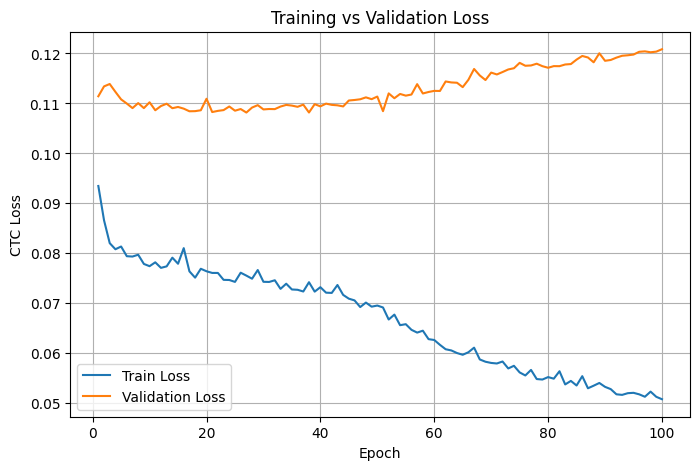

Loss curve saved at: checkpoints/loss_curve.png


<Figure size 640x480 with 0 Axes>

In [6]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# ------------------------
# Device and AMP
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
scaler = torch.amp.GradScaler()  # new AMP API

# ------------------------
# DataLoaders (define before)
# ------------------------
# train_loader, val_loader
# train_dataset.charset is the charset (list of characters)
# Make sure blank index = 0 for CTC
charset = train_dataset.charset
num_classes = len(charset)  # include blank

# ------------------------
# Model, optimizer, scheduler
# ------------------------
model = OCRModelResNet18(num_classes=num_classes, 
                         img_channels=cfg["num_channels"],
                         hidden_size=cfg["hidden_size"]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg["learning_rate"], weight_decay=cfg["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []
val_losses = []

best_val_loss = float('inf')  # track best model

# ------------------------
# Greedy CTC Decoder
# ------------------------
def greedy_ctc_decode(preds, charset):
    preds = preds.detach().cpu()
    argmax_preds = preds.argmax(2)  # [seq_len, batch]
    decoded_texts = []

    for b in range(argmax_preds.shape[1]):
        text = []
        prev_idx = 0
        for t in range(argmax_preds.shape[0]):
            idx = argmax_preds[t, b].item()
            if idx != 0 and idx != prev_idx:  # skip blanks and repeated
                text.append(charset[idx])
            prev_idx = idx
        decoded_texts.append("".join(text))
    return decoded_texts

# ------------------------
# Training Loop
# ------------------------
for epoch in range(1, cfg["epochs"] + 1):
    model.train()
    running_loss = 0.0

    for imgs, labels, label_lens in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Train)"):
        imgs, labels = imgs.to(device), labels.to(device)
        label_lens = label_lens.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            preds = model(imgs)  # [seq_len, batch, num_classes]
            batch_size = imgs.size(0)
            seq_len = preds.size(0)

            pred_lengths = torch.full((batch_size,), seq_len, dtype=torch.long, device=device)
            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)

        if torch.isnan(loss) or torch.isinf(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for imgs, labels, label_lens in tqdm(val_loader, desc=f"Epoch {epoch}/{cfg['epochs']} (Val)"):
            imgs, labels, label_lens = imgs.to(device), labels.to(device), label_lens.to(device)

            preds = model(imgs)
            batch_size = imgs.size(0)
            seq_len = preds.size(0)
            pred_lengths = torch.full((batch_size,), seq_len, dtype=torch.long, device=device)

            loss = model.compute_ctc_loss(preds, labels, pred_lengths, label_lens)
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{cfg['epochs']}] → Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # -------------------
    # Save sample prediction
    # -------------------
    sample_img, _, _ = next(iter(val_loader))
    sample_img = sample_img.to(device)
    preds = model(sample_img)
    decoded_texts = greedy_ctc_decode(preds, charset)

    img_to_save = TF.to_pil_image(sample_img[0].cpu())
    sample_save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}_sample.png")
    img_to_save.save(sample_save_path)

    print(f"Sample prediction saved: {sample_save_path} → Predicted text: {decoded_texts[0]}")

    # -------------------
    # Save best model
    # -------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"✨ New best model saved at epoch {epoch} → {best_model_path}")

    # Save current epoch checkpoint anyway
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"crnn_epoch_{epoch}.pth"))
    scheduler.step()

# -------------------
# Plot and save loss curves
# -------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Save plot as PNG
loss_curve_path = os.path.join(checkpoint_dir, "loss_curve.png")
plt.savefig(loss_curve_path)
print(f"Loss curve saved at: {loss_curve_path}")


In [7]:
import os
import random
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import yaml
from Levenshtein import distance as levenshtein_distance  # For CER calculation

# -----------------------------
# Load charset
# -----------------------------
def load_charset(charset_path):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = f.read().strip()
    return ["<blank>"] + list(chars)  # blank index = 0

# -----------------------------
# Image preprocessing
# -----------------------------
def preprocess_image(img_path, img_h=32, img_w=512):
    img = Image.open(img_path).convert("L")
    w, h = img.size
    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    return torch.tensor(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

# -----------------------------
# Greedy CTC decode
# -----------------------------
def greedy_ctc_decode(preds, charset):
    preds = preds.detach().cpu()
    argmax_preds = preds.argmax(2)  # [seq_len, batch]
    decoded_texts = []

    for b in range(argmax_preds.shape[1]):
        text = []
        prev_idx = 0
        for t in range(argmax_preds.shape[0]):
            idx = argmax_preds[t, b].item()
            if idx != 0 and idx != prev_idx:  # skip blanks and repeated
                text.append(charset[idx])
            prev_idx = idx
        decoded_texts.append("".join(text))
    return decoded_texts[0]

# -----------------------------
# Character Error Rate (CER)
# -----------------------------
def cer(pred, gt):
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    return levenshtein_distance(pred, gt) / len(gt)

# -----------------------------
# Inference function
# -----------------------------
def inference(img_path, ckpt_path, cfg_path="config.yaml"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load config
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    # Load charset
    charset = load_charset(cfg["charset_path"])
    num_classes = len(charset)

    # Load model
    model = OCRModelResNet18(
        num_classes=num_classes,
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"]
    ).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # Preprocess image
    img = preprocess_image(img_path, cfg["img_height"], cfg["img_width"]).to(device)

    # Forward pass
    with torch.no_grad():
        preds = model(img)

    # Decode prediction
    text = greedy_ctc_decode(preds, charset)

    return text

# -----------------------------
# Evaluate random samples with CER
# -----------------------------
def evaluate_samples(test_dir, ckpt_path, cfg_path="config.yaml", num_samples=15):
    all_imgs = [f for f in os.listdir(test_dir) if f.endswith(".png")]
    random.shuffle(all_imgs)
    selected = all_imgs[:num_samples]

    print("\n===== OCR INFERENCE & CER =====\n")
    total_cer = 0.0

    for img_name in selected:
        base = img_name.replace(".png", "")
        gt_file = os.path.join(test_dir, base + ".txt")
        img_file = os.path.join(test_dir, img_name)

        gt_text = ""
        if os.path.exists(gt_file):
            with open(gt_file, "r", encoding="utf-8") as f:
                gt_text = f.read().strip()

        pred_text = inference(img_file, ckpt_path, cfg_path)
        sample_cer = cer(pred_text, gt_text)
        total_cer += sample_cer

        print(f"Image: {img_name}")
        print(f"GT   : {gt_text}")
        print(f"Pred : {pred_text}")
        print(f"CER  : {sample_cer:.4f}")
        print("-" * 50)

    print(f"\nAverage CER over {num_samples} samples: {total_cer / num_samples:.4f}")

# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    evaluate_samples(
        test_dir="data/ocr_dataset/test",
        ckpt_path="checkpoints/best_model.pth",
        cfg_path="config.yaml",
        num_samples=15
    )



===== OCR INFERENCE & CER =====

Image: 00113.png
GT   : १४ असोज, काठमाडौं
Pred : ा
CER  : 0.9412
--------------------------------------------------
Image: 00311.png
GT   : इटहरी रहिपुरमा सञ्चालित
Pred : ा
CER  : 0.9565
--------------------------------------------------
Image: 00221.png
GT   : काठमाडौंमा शुक्रबार सूचना
Pred : ा
CER  : 0.9600
--------------------------------------------------
Image: 00058.png
GT   : काठमाडौं । सनम
Pred : ा
CER  : 0.9286
--------------------------------------------------
Image: 00140.png
GT   : काठमाडौं । इपिएस
Pred : ा
CER  : 0.9375
--------------------------------------------------
Image: 00302.png
GT   : काठमाडौं / रास–
Pred : ा
CER  : 0.9333
--------------------------------------------------
Image: 00444.png
GT   : गठबन्धनको सोमबार बसेको
Pred : ा
CER  : 0.9545
--------------------------------------------------
Image: 00150.png
GT   : काठमाडौं, २४ मंसिर
Pred : ा
CER  : 0.9444
--------------------------------------------------
Image: 00367.png
GT   : 

In [12]:
import os
import random
import matplotlib.pyplot as plt

def visualize_batch_predictions(test_dir, ckpt_path, cfg_path="config.yaml", num_samples=9):
    """
    Visualize OCR predictions for a batch of images.
    Args:
        test_dir: folder containing .png images and corresponding .txt GT files
        ckpt_path: path to saved model
        cfg_path: config.yaml path
        num_samples: number of random images to show
    """
    # Get all PNG images
    all_imgs = [f for f in os.listdir(test_dir) if f.endswith(".png")]
    random.shuffle(all_imgs)
    selected = all_imgs[:num_samples]

    # Setup plot grid
    cols = 3
    rows = (len(selected) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))

    for idx, img_name in enumerate(selected):
        base = img_name.replace(".png", "")
        img_path = os.path.join(test_dir, img_name)
        gt_file = os.path.join(test_dir, base + ".txt")

        # Load GT text
        gt_text = ""
        if os.path.exists(gt_file):
            with open(gt_file, "r", encoding="utf-8") as f:
                gt_text = f.read().strip()

        # Get prediction and PIL image
        pred_text, pil_img = inference(img_path, ckpt_path, cfg_path)
        sample_cer = cer(pred_text, gt_text)

        # Plot
        plt.subplot(rows, cols, idx+1)
        plt.imshow(pil_img, cmap="gray")
        plt.axis("off")
        plt.title(f"GT   : {gt_text}\nPred : {pred_text}\nCER  : {sample_cer:.4f}", fontsize=10)

    plt.tight_layout()
    plt.show()


In [8]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import yaml
from Levenshtein import distance as levenshtein_distance  # For CER calculation
import os

# -----------------------------
# Load charset
# -----------------------------
def load_charset(charset_path):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = f.read().strip()
    return ["<blank>"] + list(chars)  # blank index = 0

# -----------------------------
# Image preprocessing
# -----------------------------
def preprocess_image(img_path, img_h=32, img_w=512):
    img = Image.open(img_path).convert("L")
    w, h = img.size
    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    return torch.tensor(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

# -----------------------------
# Greedy CTC decode
# -----------------------------
def greedy_ctc_decode(preds, charset):
    preds = preds.detach().cpu()
    argmax_preds = preds.argmax(2)  # [seq_len, batch]
    text = []
    prev_idx = 0
    for t in range(argmax_preds.shape[0]):
        idx = argmax_preds[t, 0].item()
        if idx != 0 and idx != prev_idx:
            text.append(charset[idx])
        prev_idx = idx
    return "".join(text)

# -----------------------------
# Character Error Rate (CER)
# -----------------------------
def cer(pred, gt):
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    return levenshtein_distance(pred, gt) / len(gt)

# -----------------------------
# Inference function
# -----------------------------
def inference(img_path, ckpt_path, cfg_path="config.yaml"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load config
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    # Load charset
    charset = load_charset(cfg["charset_path"])
    num_classes = len(charset)

    # Load model
    model = OCRModelResNet18(
        num_classes=num_classes,
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"]
    ).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # Preprocess image
    img = preprocess_image(img_path, cfg["img_height"], cfg["img_width"]).to(device)

    # Forward pass
    with torch.no_grad():
        preds = model(img)

    # Decode prediction
    text = greedy_ctc_decode(preds, charset)
    return text

# -----------------------------
# Run on single image
# -----------------------------
if __name__ == "__main__":
    img_path = "data/ocr_dataset/test/00027.png"
    gt_path = img_path.replace(".png", ".txt")

    if os.path.exists(gt_path):
        with open(gt_path, "r", encoding="utf-8") as f:
            gt_text = f.read().strip()
    else:
        gt_text = "[Missing GT]"

    pred_text = inference(img_path, ckpt_path="checkpoints/best_model.pth", cfg_path="config.yaml")
    error_rate = cer(pred_text, gt_text)

    print(f"Image: {img_path}")
    print(f"Ground Truth: {gt_text}")
    print(f"Predicted   : {pred_text}")
    print(f"Character Error Rate (CER): {error_rate:.4f}")


Image: data/ocr_dataset/test/00027.png
Ground Truth: काठमाडौं । सन्तान
Predicted   : ा
Character Error Rate (CER): 0.9412


In [13]:
import os
import random
import matplotlib.pyplot as plt

def visualize_batch_predictions(test_dir, ckpt_path, cfg_path="config.yaml", num_samples=9):
    """
    Visualize OCR predictions for a batch of images.
    Args:
        test_dir: folder containing .png images and corresponding .txt GT files
        ckpt_path: path to saved model
        cfg_path: config.yaml path
        num_samples: number of random images to show
    """
    
    # Get all PNG images
    all_imgs = [f for f in os.listdir(test_dir) if f.endswith(".png")]
    random.shuffle(all_imgs)
    selected = all_imgs[:num_samples]

    # Setup plot grid
    cols = 3
    rows = (len(selected) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))

    for idx, img_name in enumerate(selected):
        base = img_name.replace(".png", "")
        img_path = os.path.join(test_dir, img_name)
        gt_file = os.path.join(test_dir, base + ".txt")

        # Load GT text
        gt_text = ""
        if os.path.exists(gt_file):
            with open(gt_file, "r", encoding="utf-8") as f:
                gt_text = f.read().strip()

        # Get prediction and PIL image
        pred_text, pil_img = inference(img_path, ckpt_path, cfg_path)
        sample_cer = cer(pred_text, gt_text)

        # Plot
        plt.subplot(rows, cols, idx+1)
        plt.imshow(pil_img, cmap="gray")
        plt.axis("off")
        plt.title(f"GT   : {gt_text}\nPred : {pred_text}\nCER  : {sample_cer:.4f}", fontsize=10)

    plt.tight_layout()
    plt.show()


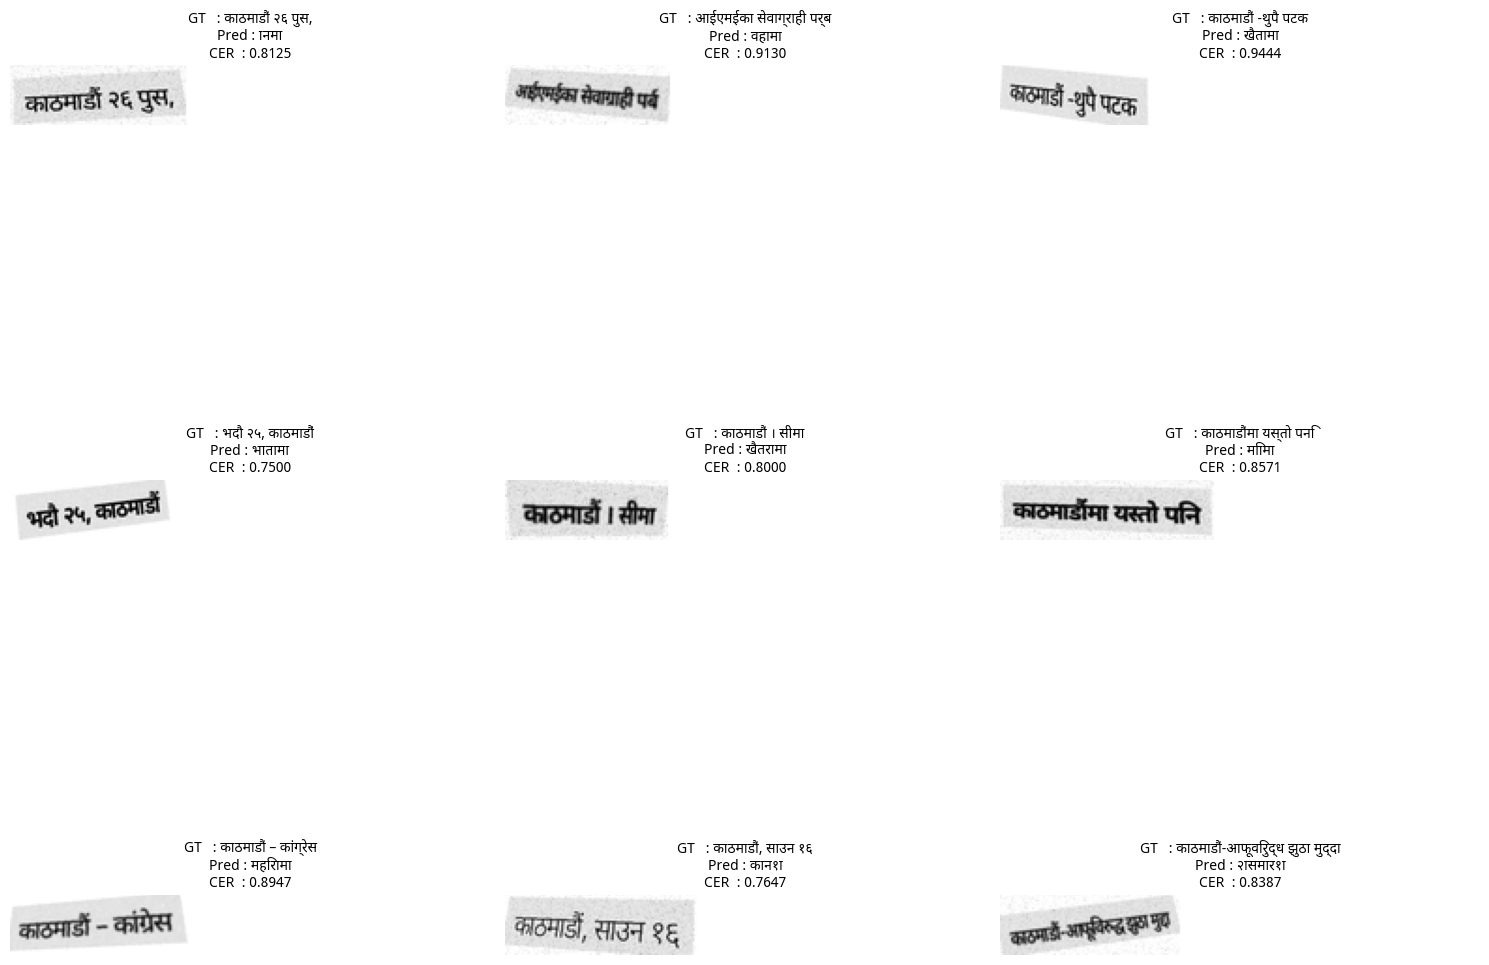

In [20]:
import os
import random
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import yaml
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from Levenshtein import distance as levenshtein_distance  # for CER

# -----------------------------
# Load charset
# -----------------------------
def load_charset(charset_path):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = f.read().strip()
    return ["<blank>"] + list(chars)  # blank index = 0

# -----------------------------
# Image preprocessing
# -----------------------------
def preprocess_image(img_path, img_h=32, img_w=512):
    img = Image.open(img_path).convert("L")
    w, h = img.size
    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img_norm = np.array(img).astype(np.float32) / 255.0
    img_norm = (img_norm - 0.5) / 0.5
    tensor_img = torch.tensor(img_norm).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return tensor_img, img  # return tensor for model + original PIL for plotting

# -----------------------------
# Greedy CTC decode
# -----------------------------
def greedy_ctc_decode(preds, charset):
    preds = preds.detach().cpu()
    argmax_preds = preds.argmax(2)  # [seq_len, batch]
    decoded_texts = []

    for b in range(argmax_preds.shape[1]):
        text = []
        prev_idx = 0
        for t in range(argmax_preds.shape[0]):
            idx = argmax_preds[t, b].item()
            if idx != 0 and idx != prev_idx:  # skip blanks and repeated
                text.append(charset[idx])
            prev_idx = idx
        decoded_texts.append("".join(text))
    return decoded_texts[0]

# -----------------------------
# Character Error Rate (CER)
# -----------------------------
def cer(pred, gt):
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    return levenshtein_distance(pred, gt) / len(gt)

# -----------------------------
# OCR Inference (return PIL too)
# -----------------------------
def inference(img_path, ckpt_path, cfg_path="config.yaml"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load config
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    # Load charset
    charset = load_charset(cfg["charset_path"])
    num_classes = len(charset)

    # Load model
    model = OCRModelResNet18(
        num_classes=num_classes,
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"]
    ).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # Preprocess image
    tensor_img, pil_img = preprocess_image(img_path, cfg["img_height"], cfg["img_width"])
    tensor_img = tensor_img.to(device)

    # Forward pass
    with torch.no_grad():
        preds = model(tensor_img)

    # Decode
    pred_text = greedy_ctc_decode(preds, charset)
    return pred_text, pil_img

# -----------------------------
# Batch visualization
# -----------------------------
def visualize_batch_predictions(test_dir, ckpt_path, cfg_path="config.yaml", num_samples=9):
    """
    Visualize OCR predictions for a batch of images.
    """
    # Get random images
    all_imgs = [f for f in os.listdir(test_dir) if f.endswith(".png")]
    random.shuffle(all_imgs)
    selected = all_imgs[:num_samples]

    # Grid
    cols = 3
    rows = (len(selected) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))

    # Devanagari font
    font_path = "fonts/NotoSansDevanagari-Regular.ttf"
    prop = fm.FontProperties(fname=font_path)

    for idx, img_name in enumerate(selected):
        base = img_name.replace(".png", "")
        img_path = os.path.join(test_dir, img_name)
        gt_file = os.path.join(test_dir, base + ".txt")

        gt_text = ""
        if os.path.exists(gt_file):
            with open(gt_file, "r", encoding="utf-8") as f:
                gt_text = f.read().strip()

        pred_text, pil_img = inference(img_path, ckpt_path, cfg_path)
        sample_cer = cer(pred_text, gt_text)

        plt.subplot(rows, cols, idx+1)
        plt.imshow(pil_img, cmap="gray")
        plt.axis("off")
        plt.title(f"GT   : {gt_text}\nPred : {pred_text}\nCER  : {sample_cer:.4f}",
                  fontsize=10, fontproperties=prop)

    plt.tight_layout()
    plt.show()

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    visualize_batch_predictions(
        test_dir="data/ocr_dataset/test",
        ckpt_path="checkpoints/crnn_epoch_88.pth",
        cfg_path="config.yaml",
        num_samples=9
    )


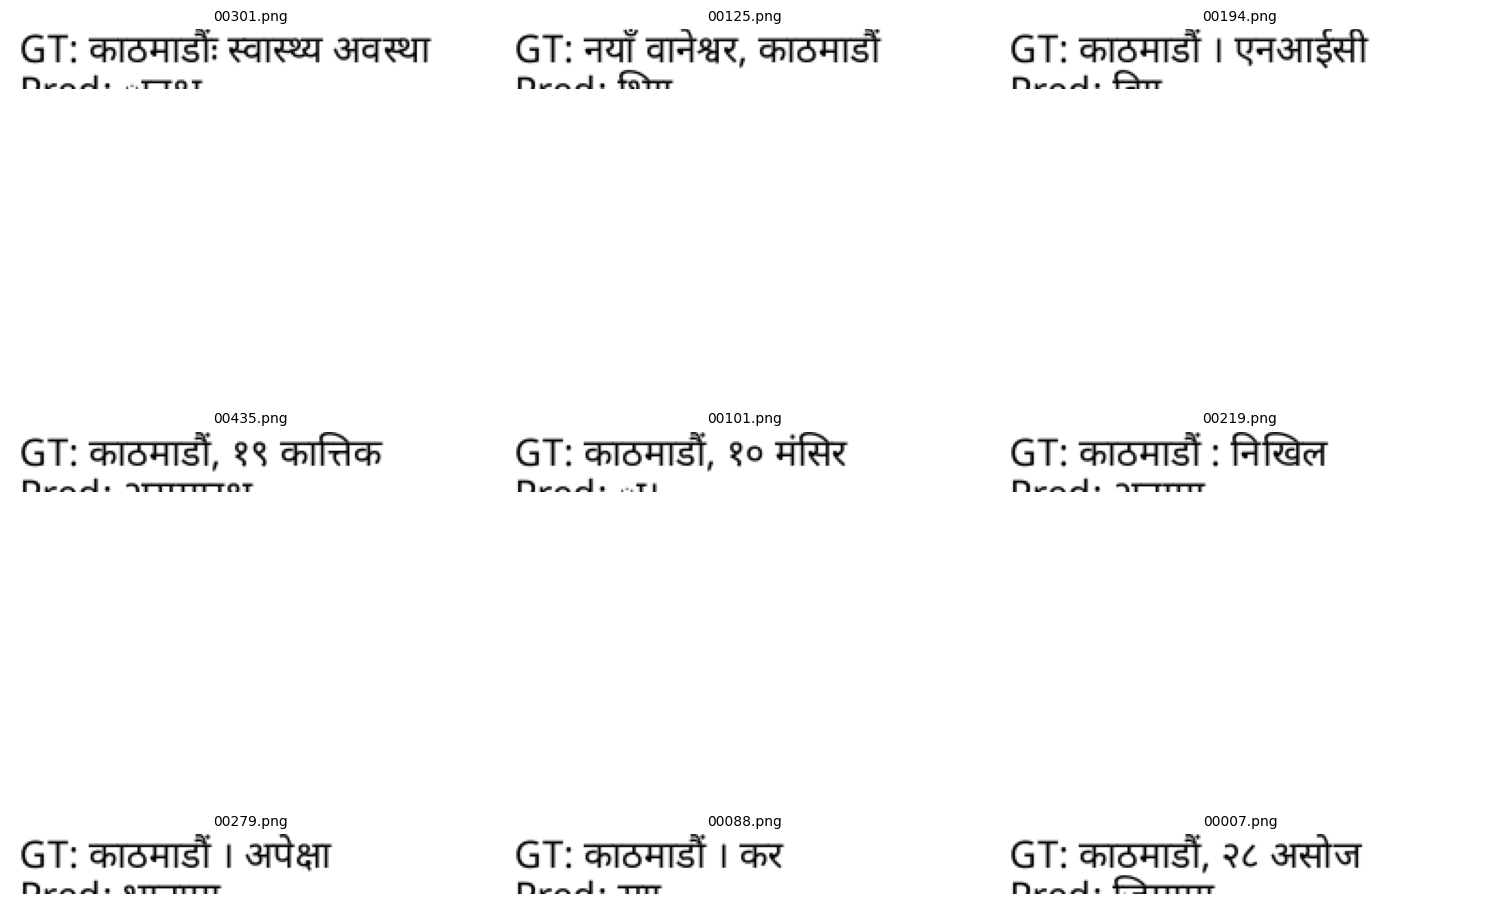


Predicted images saved in: predictions


In [19]:
import os
import random
import torch
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import yaml
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance  # for CER

# -----------------------------
# Load charset
# -----------------------------
def load_charset(charset_path):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = f.read().strip()
    return ["<blank>"] + list(chars)  # blank index = 0

# -----------------------------
# Image preprocessing
# -----------------------------
def preprocess_image(img_path, img_h=32, img_w=512):
    img = Image.open(img_path).convert("L")
    w, h = img.size
    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img_norm = np.array(img).astype(np.float32) / 255.0
    img_norm = (img_norm - 0.5) / 0.5
    tensor_img = torch.tensor(img_norm).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return tensor_img, img  # return tensor for model + original PIL for plotting

# -----------------------------
# Greedy CTC decode
# -----------------------------
def greedy_ctc_decode(preds, charset):
    preds = preds.detach().cpu()
    argmax_preds = preds.argmax(2)  # [seq_len, batch]
    decoded_texts = []

    for b in range(argmax_preds.shape[1]):
        text = []
        prev_idx = 0
        for t in range(argmax_preds.shape[0]):
            idx = argmax_preds[t, b].item()
            if idx != 0 and idx != prev_idx:  # skip blanks and repeated
                text.append(charset[idx])
            prev_idx = idx
        decoded_texts.append("".join(text))
    return decoded_texts[0]

# -----------------------------
# Character Error Rate (CER)
# -----------------------------
def cer(pred, gt):
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    return levenshtein_distance(pred, gt) / len(gt)

# -----------------------------
# OCR Inference (return PIL too)
# -----------------------------
def inference(img_path, ckpt_path, cfg_path="config.yaml"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load config
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    # Load charset
    charset = load_charset(cfg["charset_path"])
    num_classes = len(charset)

    # Load model
    model = OCRModelResNet18(
        num_classes=num_classes,
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"]
    ).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # Preprocess image
    tensor_img, pil_img = preprocess_image(img_path, cfg["img_height"], cfg["img_width"])
    tensor_img = tensor_img.to(device)

    # Forward pass
    with torch.no_grad():
        preds = model(tensor_img)

    # Decode
    pred_text = greedy_ctc_decode(preds, charset)
    return pred_text, pil_img

# -----------------------------
# Visualize batch and save predictions
# -----------------------------
def visualize_and_save_predictions(test_dir, ckpt_path, cfg_path="config.yaml", num_samples=9, save_dir="predictions"):
    os.makedirs(save_dir, exist_ok=True)

    # Random selection
    all_imgs = [f for f in os.listdir(test_dir) if f.endswith(".png")]
    random.shuffle(all_imgs)
    selected = all_imgs[:num_samples]

    # Load font
    font_path = "fonts/NotoSansDevanagari-Regular.ttf"
    font = ImageFont.truetype(font_path, 20)

    # Plot grid
    cols = 3
    rows = (len(selected) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))

    for idx, img_name in enumerate(selected):
        base = img_name.replace(".png", "")
        img_path = os.path.join(test_dir, img_name)
        gt_file = os.path.join(test_dir, base + ".txt")

        # Ground truth
        gt_text = ""
        if os.path.exists(gt_file):
            with open(gt_file, "r", encoding="utf-8") as f:
                gt_text = f.read().strip()

        # Inference
        pred_text, pil_img = inference(img_path, ckpt_path, cfg_path)
        sample_cer = cer(pred_text, gt_text)

        # Draw text on image
        draw = ImageDraw.Draw(pil_img)
        text_to_draw = f"GT: {gt_text}\nPred: {pred_text}\nCER: {sample_cer:.4f}"
        draw.rectangle([(0,0),(pil_img.width,60)], fill=(255))  # white rectangle for text
        draw.text((5, 0), text_to_draw, fill=(0), font=font)

        # Save image
        save_path = os.path.join(save_dir, f"{base}_pred.png")
        pil_img.save(save_path)

        # Show in matplotlib
        plt.subplot(rows, cols, idx+1)
        plt.imshow(pil_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{img_name}", fontsize=10)

    plt.tight_layout()
    plt.show()
    print(f"\nPredicted images saved in: {save_dir}")

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    visualize_and_save_predictions(
        test_dir="data/ocr_dataset/test",
        ckpt_path="checkpoints/crnn_epoch_66.pth",
        cfg_path="config.yaml",
        num_samples=9,
        save_dir="predictions"
    )


/tmp/ipykernel_3858536/705106578.py:45: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3858536/705106578.py:45: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_3858536/705106578.py:45: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3858536/705106578.py:45: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3858536/705106578.py:45: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3858536/705106578.py:45: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3858536/705106578.py:45: UserWarning: Glyph 2380 (\N{DEVANAGARI VOWEL SIGN AU}) missing from font(s) DejaVu Sans.
 

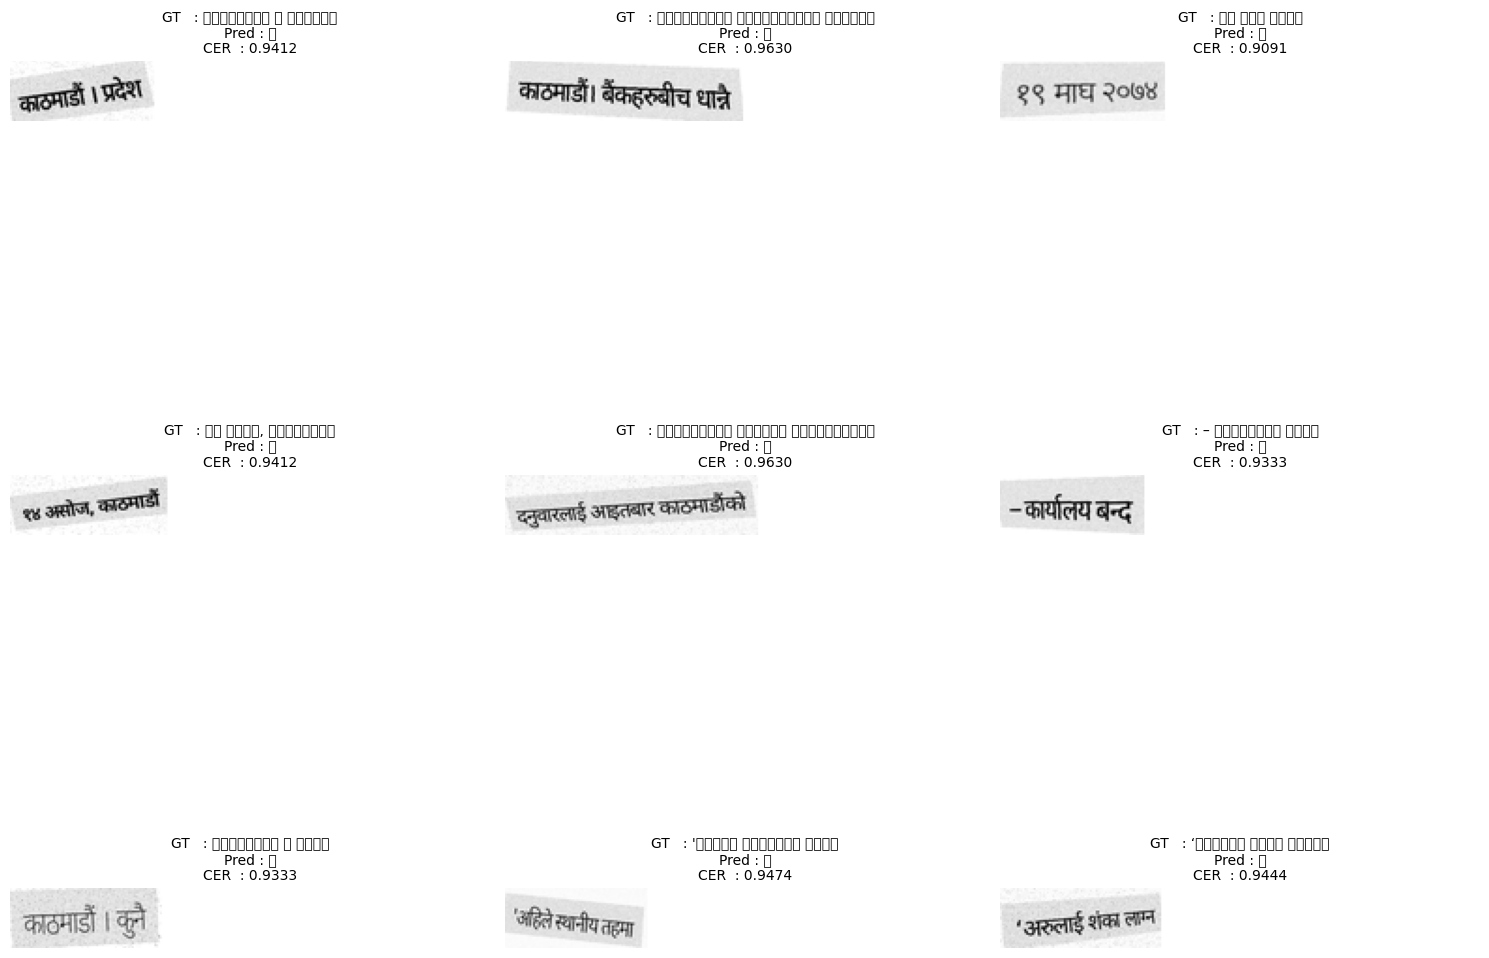

In [14]:
visualize_batch_predictions(
    test_dir="data/ocr_dataset/test",
    ckpt_path="checkpoints/crnn_epoch_66.pth",
    cfg_path="config.yaml",
    num_samples=9  # visualize 9 random samples
)


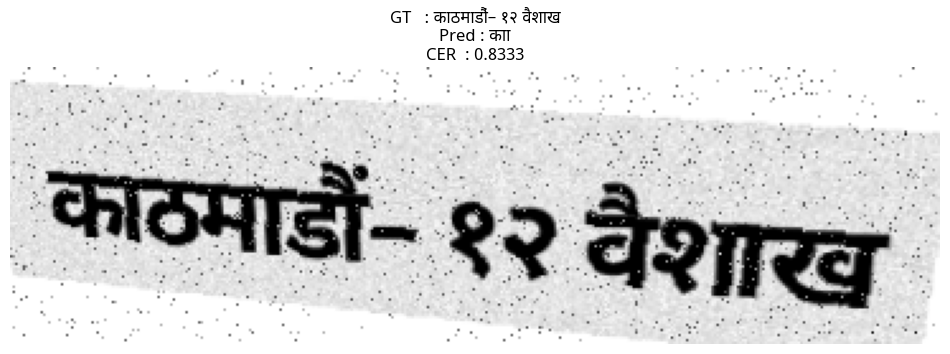

In [17]:
import os
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import yaml
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from Levenshtein import distance as levenshtein_distance  # for CER

# -----------------------------
# Load charset
# -----------------------------
def load_charset(charset_path):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = f.read().strip()
    return ["<blank>"] + list(chars)  # blank index = 0

# -----------------------------
# Image preprocessing
# -----------------------------
def preprocess_image(img_path, img_h=32, img_w=512):
    img = Image.open(img_path).convert("L")
    w, h = img.size
    new_h = img_h
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.LANCZOS)

    if new_w < img_w:
        padded = Image.new("L", (img_w, new_h), 255)
        padded.paste(img, (0, 0))
        img = padded
    else:
        img = img.crop((0, 0, img_w, new_h))

    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    return torch.tensor(img).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]

# -----------------------------
# Greedy CTC decode
# -----------------------------
def greedy_ctc_decode(preds, charset):
    preds = preds.detach().cpu()
    argmax_preds = preds.argmax(2)  # [seq_len, batch]
    decoded_texts = []

    for b in range(argmax_preds.shape[1]):
        text = []
        prev_idx = 0
        for t in range(argmax_preds.shape[0]):
            idx = argmax_preds[t, b].item()
            if idx != 0 and idx != prev_idx:  # skip blanks and repeated
                text.append(charset[idx])
            prev_idx = idx
        decoded_texts.append("".join(text))
    return decoded_texts[0]

# -----------------------------
# Character Error Rate (CER)
# -----------------------------
def cer(pred, gt):
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    return levenshtein_distance(pred, gt) / len(gt)

# -----------------------------
# OCR Inference
# -----------------------------
def inference(img_path, ckpt_path, cfg_path="config.yaml"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load config
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    # Load charset
    charset = load_charset(cfg["charset_path"])
    num_classes = len(charset)

    # Load model
    model = OCRModelResNet18(
        num_classes=num_classes,
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"]
    ).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # Preprocess image
    img = preprocess_image(img_path, cfg["img_height"], cfg["img_width"]).to(device)

    # Forward pass
    with torch.no_grad():
        preds = model(img)

    # Decode
    text = greedy_ctc_decode(preds, charset)
    return text

# -----------------------------
# Visualization
# -----------------------------
def visualize_prediction(img_path, ckpt_path, cfg_path, gt_text=""):
    pred_text = inference(img_path, ckpt_path, cfg_path)
    sample_cer = cer(pred_text, gt_text)

    # Load image for display
    img = Image.open(img_path).convert("L")
    img_np = np.array(img)

    # Set Devanagari font
    font_path = "fonts/NotoSansDevanagari-Regular.ttf"
    prop = fm.FontProperties(fname=font_path)

    plt.figure(figsize=(12, 4))
    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.title(f"GT   : {gt_text}\nPred : {pred_text}\nCER  : {sample_cer:.4f}", fontproperties=prop, fontsize=12)
    plt.show()

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    test_img = "data/ocr_dataset/test/00006.png"
    gt_file = test_img.replace(".png", ".txt")
    gt_text = ""
    if os.path.exists(gt_file):
        with open(gt_file, "r", encoding="utf-8") as f:
            gt_text = f.read().strip()

    visualize_prediction(test_img, "checkpoints/crnn_epoch_66.pth", "config.yaml", gt_text)


In [16]:
import os

path = "checkpoints"
files = os.listdir(path)

print(files)


['crnn_epoch_1.pth', 'crnn_epoch_63.pth', 'epoch_25_sample.png', 'crnn_epoch_11.pth', 'epoch_43_sample.png', 'crnn_epoch_12.pth', 'crnn_epoch_83.pth', 'epoch_77_sample.png', 'epoch_45_sample.png', 'epoch_58_sample.png', 'epoch_35_sample.png', 'epoch_20_sample.png', 'crnn_epoch_67.pth', 'crnn_epoch_18.pth', 'crnn_epoch_6.pth', 'epoch_48_sample.png', 'crnn_epoch_52.pth', 'epoch_6_sample.png', 'crnn_epoch_10.pth', 'epoch_44_sample.png', 'crnn_epoch_2.pth', 'crnn_epoch_85.pth', 'crnn_epoch_46.pth', 'crnn_epoch_31.pth', 'epoch_99_sample.png', 'epoch_60_sample.png', 'epoch_100_sample.png', 'epoch_64_sample.png', 'epoch_11_sample.png', 'crnn_epoch_4.pth', 'epoch_75_sample.png', 'epoch_65_sample.png', 'crnn_epoch_22.pth', 'epoch_8_sample.png', 'epoch_55_sample.png', 'nepali_crnn_ctc.pth', 'crnn_epoch_41.pth', 'crnn_epoch_79.pth', 'crnn_epoch_43.pth', 'epoch_97_sample.png', 'crnn_epoch_30.pth', 'epoch_12_sample.png', 'epoch_1_sample.png', 'crnn_epoch_35.pth', 'epoch_13_sample.png', 'epoch_53_sa